In [88]:
import numpy as np 
np.set_printoptions(threshold=np.nan) 
import pandas as pd
import warnings
import sklearn
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
warnings.filterwarnings('ignore')



2 axes expliquent 0.9898879529268558% de la variance


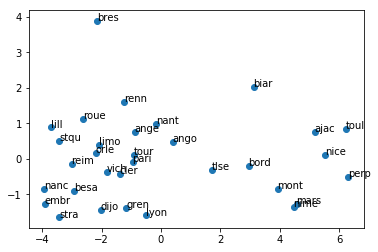

In [89]:
def pca_premier_exo(path='villes.csv', variance=0.7, print_mode=True):
    data = pd.read_csv(path, sep=';')
    X = data.ix[:, 1:len(data)-1].values
    labels = data.ix[:, 0].values
    scaler = StandardScaler()
    normalized = scaler.fit_transform(X)
    for x in range(len(data)):
        pca = PCA(n_components=x)
        pca.fit(normalized)
        if sum(pca.explained_variance_ratio_) > variance and x >1:
            print('{}'.format(x) + ' axes expliquent ' + '{}'.format(sum(pca.explained_variance_ratio_)) + '% de la variance')
            break
    
    X_pca = pca.fit_transform(normalized)
    if print_mode:
        plt.scatter(X_pca[:, 0], X_pca[:, 1])
        for label, x, y in zip(labels, X_pca[:, 0], X_pca[:, 1]):
            plt.annotate(label, xy=(x, y), xytext=(-0.2, 0.2), textcoords='offset points')
        plt.show()
        plt.close()
    return [pca,X_pca]
        
        
donnees_villes = pca_premier_exo()

#pca_premier_exo(path='crime.csv')

La première variable sortie par la méthode PCA explique plus de 70% de la variance.
On décide de prendre aussi une deuxième variable pour pouvoir les représenter graphiquement.


2 axes expliquent 0.764811620190864% de la variance


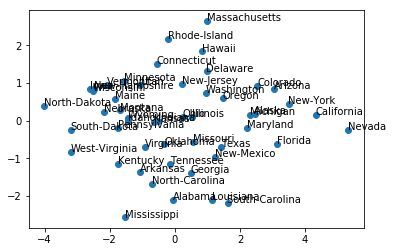

In [90]:
donnees_crimes = pca_premier_exo('crime.csv')

# 

In [91]:
def kmeans_premier_exo(path='villes.csv', print_mode=True, nb_class=3):
    data = pd.read_csv(path, sep=';')
    X = data.ix[:, 1:len(data)-1].values
    labels = data.ix[:, 0].values
    scaler = StandardScaler()
    normalized = scaler.fit_transform(X)
    pca = PCA(n_components=len(X[0])-1)
    pca.fit(normalized)
    X_pca = pca.fit_transform(normalized)
    kmeansoutput = KMeans(n_clusters=nb_class, random_state=0).fit(X_pca)
    if print_mode:
        plt.figure(str(nb_class) + ' Cluster K-Means')
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeansoutput.labels_)
        plt.title(str(nb_class) + ' Cluster K-Means')
        plt.show()
    return [kmeansoutput,X_pca]

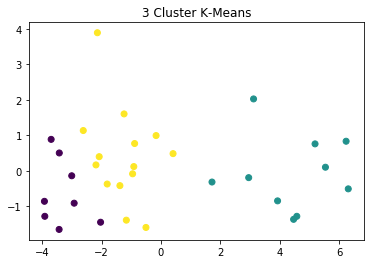

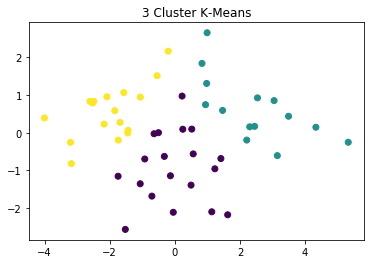

In [92]:
km_villes = kmeans_premier_exo()
km_crimes = kmeans_premier_exo('crime.csv')

On obtient deux clusters qui semblent bons.

In [93]:
essai = 0
def agglo(path='villes.csv', print_mode=True, methode='ward', nb_class=3):
    global essai
    data = pd.read_csv(path, sep=';')
    X = data.ix[:, 1:len(data)-1].values
    labels = data.ix[:, 0].values
    scaler = StandardScaler()
    normalized = scaler.fit_transform(X)
    pca = PCA(n_components=len(X[0])-1)
    pca.fit(normalized)
    X_pca = pca.fit_transform(normalized)
    model = AgglomerativeClustering(linkage=methode,
                                    n_clusters=nb_class)
    model.fit(X_pca)
    if print_mode:
        plt.figure('3 AgglomerativeClustering')
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=model.labels_)
        plt.title('3 AgglomerativeClustering, methode:' + methode)
        plt.show()
    return [model,X_pca]

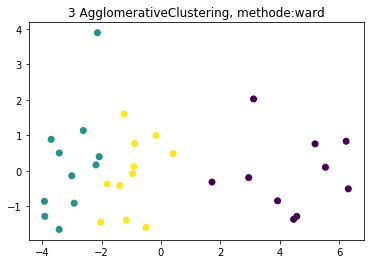

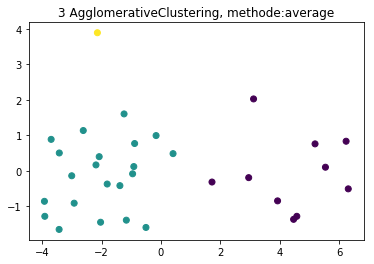

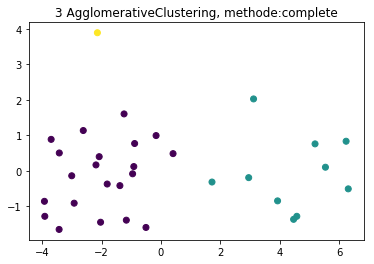

In [94]:
algo_ward = agglo('villes.csv', methode='ward')
algo_average = agglo('villes.csv', methode='average')
algo_complete = agglo('villes.csv', methode='complete')

On obtient donc d'autres clusters à partir des mêmes donnes.
Les méthodes sont différentes.
On remarque que la methode complete donne le même résultat que la methode average.

In [95]:
def dunn(c, distances):
    """
    Dunn index for cluster validation (the bigger, the better)
    """
    unique_cluster_distances = np.unique(min_cluster_distances(c, distances))
    max_diameter = max(diameter(c, distances))

    if np.size(unique_cluster_distances) > 1:
        return unique_cluster_distances[1] / max_diameter
    else:
        return unique_cluster_distances[0] / max_diameter

def min_cluster_distances(c, distances):
    """Calculates the distances between the two nearest points of each cluster"""
    min_distances = np.zeros((max(c) + 1, max(c) + 1))
    for i in np.arange(0, len(c)):
        if c[i] == -1: continue
        for ii in np.arange(i + 1, len(c)):
            if c[ii] == -1: continue
            if c[i] != c[ii] and distances[i, ii] > min_distances[c[i], c[ii]]:
                min_distances[c[i], c[ii]] = min_distances[c[ii], c[i]] = distances[i, ii]
    return min_distances

def diameter(c, distances):
    """Calculates cluster diameters (the distance between the two farthest data points in a cluster)"""
    diameters = np.zeros(max(c) + 1)
    for i in np.arange(0, len(c)):
        if c[i] == -1: continue
        for ii in np.arange(i + 1, len(c)):
            if c[ii] == -1: continue
            if c[i] != -1 or c[ii] != -1 and c[i] == c[ii] and distances[i, ii] > diameters[c[i]]:
                diameters[c[i]] = distances[i, ii]
    return diameters 

In [96]:
paths = ['villes.csv', 'crime.csv']
methodes = ['ward', 'complete', 'average']


def qualite(path, nb_class, distance_methode, methode=None):

    clustering = kmeans_premier_exo(path=path, print_mode=False, nb_class=nb_class)
   
    if distance_methode == 'dunn':
        distance = sklearn.metrics.pairwise.pairwise_distances(clustering[1])
        qualite = dunn(clustering[0].fit_predict(clustering[1]),distance)
    else:
        qualite = metrics.silhouette_score(clustering[1], clustering[0].fit_predict(clustering[1]),metric='euclidean')
    return qualite

In [97]:
qualite('villes.csv', nb_class=4,distance_methode='silhouette')

0.3925585200345077

In [98]:
def max_qualite_dunn(path):
    result = 0
    nb_res = 0
    for nb_class in range(2,6):
        qualit = qualite(path, nb_class=nb_class, distance_methode='dunn')
        if qualit > result:
            result = qualit
            nb_res = nb_class
    return [result, nb_res]

def max_qualite_silhouette(path):
    result = 0
    nb_res = 0
    for nb_class in range(2,6):
        qualit = qualite(path, nb_class=nb_class, distance_methode='silhouette')
        if qualit > result:
            result = qualit
            nb_res = nb_class
    return [result, nb_res]

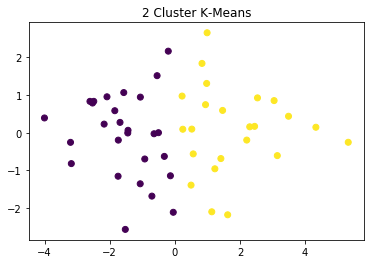

In [99]:
mq = max_qualite_dunn('crime.csv')
mc = kmeans_premier_exo('crime.csv', nb_class=mq[1])

In [100]:
mq

[3.6188217618045924, 2]

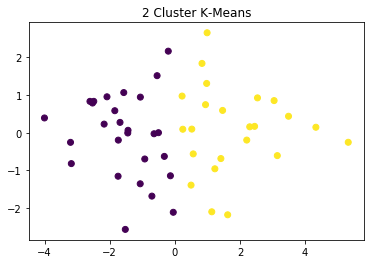

In [101]:
mq = max_qualite_silhouette('crime.csv')
mc = kmeans_premier_exo('crime.csv', nb_class=mq[1])

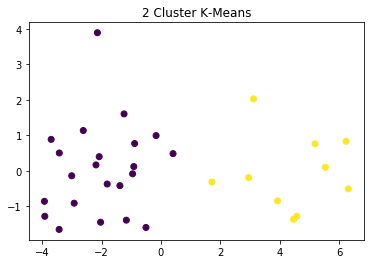

In [102]:
mq = max_qualite_dunn('villes.csv')
mc = kmeans_premier_exo('villes.csv', nb_class=mq[1])

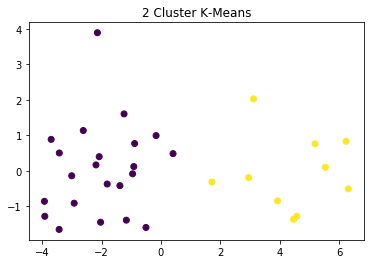

In [103]:
mq = max_qualite_silhouette('villes.csv')
mc = kmeans_premier_exo('villes.csv', nb_class=mq[1])

Finalement pour toutes les methodes et toutes les donnees, 
le nombre de clusters otpimal est 2.
Cependant pour crimes, il semble judicieux à l'oeil nu de ne pas clusteriser nos données.